<a href="https://colab.research.google.com/github/ary3120-droid/myproject/blob/main/1_21olist.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

연결


In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
# 1. 한글 폰트 설치
!apt-get -qq -y install fonts-nanum > /dev/null

# 2. 폰트 캐시 업데이트 (최신 버전 matplotlib용)
import matplotlib.font_manager as fm
import matplotlib.pyplot as plt

# 설치된 나눔 폰트 경로 확인 및 등록
fe = fm.FontEntry(
    fname='/usr/share/fonts/truetype/nanum/NanumBarunGothic.ttf',
    name='NanumBarunGothic')
fm.fontManager.ttflist.insert(0, fe)

print("✅ 폰트 설치가 완료되었습니다. [런타임 -> 런타임 다시 시작]을 누른 후 다음 단계를 진행하세요!")

✅ 폰트 설치가 완료되었습니다. [런타임 -> 런타임 다시 시작]을 누른 후 다음 단계를 진행하세요!


**환경 설정 및 공통 데이터 로드**

In [3]:
# 1. 라이브러리 설치 및 임포트
!pip install koreanize-matplotlib -q

import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns
import koreanize_matplotlib

# 2. 경로 설정
BASE_PATH = '/content/drive/MyDrive/olist/'

# 3. 데이터 로드 및 공통 전처리 (날짜 변환)
date_cols = ['order_purchase_timestamp', 'order_approved_at',
             'order_delivered_carrier_date', 'order_delivered_customer_date',
             'order_estimated_delivery_date']

# 원본 데이터 로드 (필요한 테이블만 우선 로드)
orders = pd.read_csv(os.path.join(BASE_PATH, 'olist_orders_dataset.csv'), parse_dates=date_cols)
order_items = pd.read_csv(os.path.join(BASE_PATH, 'olist_order_items_dataset.csv'))
products = pd.read_csv(os.path.join(BASE_PATH, 'olist_products_dataset.csv'))
translation = pd.read_csv(os.path.join(BASE_PATH, 'product_category_name_translation.csv'))
customers = pd.read_csv(os.path.join(BASE_PATH, 'olist_customers_dataset.csv'))

# [공통 전처리] 완전 중복 데이터 제거
orders = orders.drop_duplicates()
order_items = order_items.drop_duplicates()

print(f"✅ 공통 전처리 완료! (유효 주문: {len(orders):,}건)")

✅ 공통 전처리 완료! (유효 주문: 99,441건)


**[분석 1] 매출 및 상품 분석**

/tmp/ipython-input-2306443798.py:21: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_10_revenue.values, y=top_10_revenue.index, ax=ax[0], palette='viridis')
/tmp/ipython-input-2306443798.py:33: UserWarning: Glyph 52509 (\N{HANGUL SYLLABLE CONG}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-2306443798.py:33: UserWarning: Glyph 47588 (\N{HANGUL SYLLABLE MAE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-2306443798.py:33: UserWarning: Glyph 52636 (\N{HANGUL SYLLABLE CUL}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-2306443798.py:33: UserWarning: Glyph 50529 (\N{HANGUL SYLLABLE AEG}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-2306443798.py:33: UserWarning: Glyph 128176 (\N{MONEY BAG}) missing from font(s) DejaVu Sans.
  

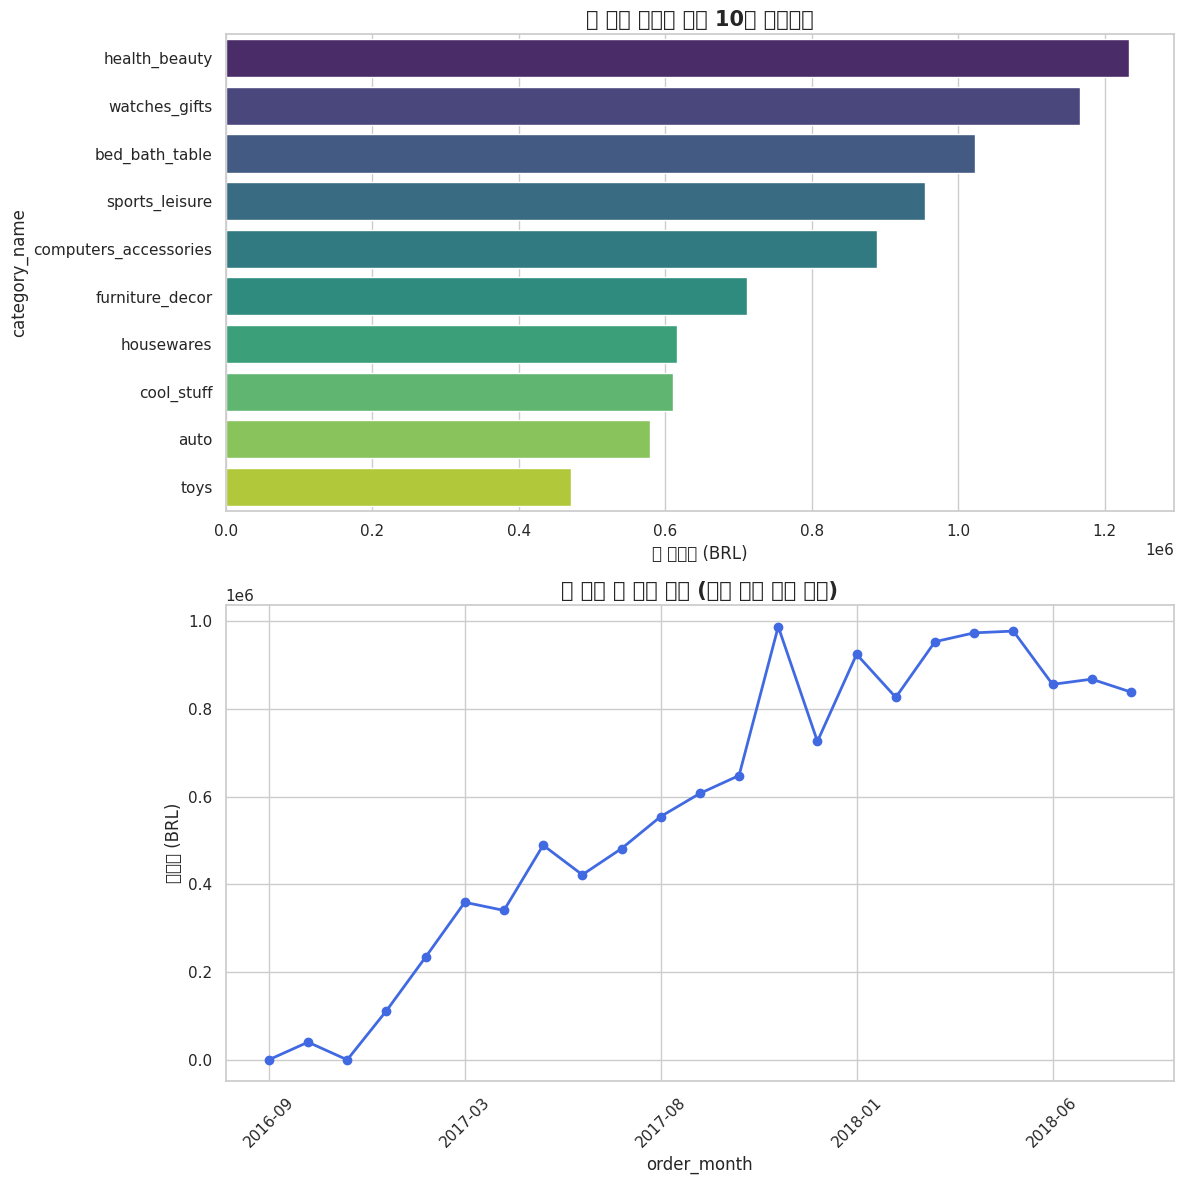

📍 분석 대상 주문 건수: 96,478건


In [4]:
# 1. 매출 분석용 테이블 조인
df_revenue = (
    orders
    .merge(order_items, on='order_id', how='inner')
    .merge(products, on='product_id', how='inner')
    .merge(translation, on='product_category_name', how='left')
)

# 2. [섹션 전처리] 매출 분석에 특화된 정제
# - '배송 완료(delivered)'된 주문만 매출로 인정
df_revenue = df_revenue[df_revenue['order_status'] == 'delivered'].copy()
# - 카테고리명 영문 변환 및 결측치 채우기
df_revenue['category_name'] = df_revenue['product_category_name_english'].fillna(df_revenue['product_category_name'])

# 3. 시각화
sns.set_theme(style="whitegrid")
fig, ax = plt.subplots(2, 1, figsize=(12, 12))

# (1) 카테고리별 매출 TOP 10
top_10_revenue = df_revenue.groupby('category_name')['price'].sum().sort_values(ascending=False).head(10)
sns.barplot(x=top_10_revenue.values, y=top_10_revenue.index, ax=ax[0], palette='viridis')
ax[0].set_title('💰 수익 기여도 상위 10개 카테고리', fontsize=15, fontweight='bold')
ax[0].set_xlabel('총 매출액 (BRL)')

# (2) 월별 매출 트렌드
df_revenue['order_month'] = df_revenue['order_purchase_timestamp'].dt.to_period('M').astype(str)
monthly_revenue = df_revenue.groupby('order_month')['price'].sum()
monthly_revenue.plot(ax=ax[1], marker='o', color='royalblue', linewidth=2)
ax[1].set_title('📈 월별 총 매출 추이 (배송 완료 주문 기준)', fontsize=15, fontweight='bold')
ax[1].set_ylabel('매출액 (BRL)')
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

print(f"📍 분석 대상 주문 건수: {df_revenue['order_id'].nunique():,}건")